I want to create another column that says whether a certain site failure overlapped with others

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from tqdm import tqdm

sns.set()
path = os.path.expanduser('~/Projects/capstone-two/data/processed/Final_Clean_Harbor_Water_Quality.csv', )
wq_df = pd.read_csv(path, parse_dates=['Sample Date'], index_col=0)

Having graph showing overlapping failures does not give me additional information on when sites fail in respect to each other. The most highly connected sites in the graph are also the most frequent ones that fail which makes sense. I want to now make a new dataframe that illustrates these connections more completely.

In [2]:
def site_fail_col(df, site, col):
    '''Creates a list of binary responses to whether the measurement failed (1) test \'col\' or not (0)
        in reference to the date of the original \'site\' sample.
        df  = pandas DataFrame from which to draw all data
        site = sampling location being tested. When site fails, what other sites fail?
        col = parameter being tested
        '''
    column = col + ' Failure'
    fail_date_df = df[(df['Sampling Location'] == site) & (df[column] == 1)]['Sample Date']
    site_set = set([(i.year, i.month) for i in fail_date_df])
    
    site_col_overlap = []
    
    # Checks to see if sample date is in set of dates where `site` failed  
    # if failures overlap, appends 1 to site_col_overlap
    for tup in df.itertuples():
        if (tup[42] == 1) & ((tup[2].year, tup[2].month) in site_set):
            site_col_overlap.append(1)
        else:
            site_col_overlap.append(0)
    
    return site_col_overlap

In [3]:
from tqdm import tqdm

chl_overlap_df = pd.DataFrame(data=wq_df['Sampling Location'])

for site in tqdm(wq_df['Sampling Location'].unique()):
    col_name = site + '_fail_overlap_chl'
    site_list = site_fail_col(wq_df, site, 'Top Active Chlorophyll \'A\' (µg/L)')
    
    chl_overlap_df[col_name] = site_list

    
ent_overlap_df = pd.DataFrame(data=wq_df['Sampling Location'])

for site in tqdm(wq_df['Sampling Location'].unique()):
    col_name = site + '_fail_overlap_ent'
    site_list = site_fail_col(wq_df, site, 'Top Enterococci Bacteria (Cells/100mL)')
    
    ent_overlap_df[col_name] = site_list


pho_overlap_df = pd.DataFrame(data=wq_df['Sampling Location'])

for site in tqdm(wq_df['Sampling Location'].unique()):
    col_name = site + '_fail_overlap_pho'
    site_list = site_fail_col(wq_df, site, 'Top Ortho-Phosphorus (mg/L)')
    
    pho_overlap_df[col_name] = site_list


100%|███████████████████████████████████████████████████████████████████████████████| 55/55 [00:14<00:00,  3.72it/s]


For these graphs, the site along the x-axis is the one who's prediction ability we are testing. If site_x fails, then what is the probability that site_y fails too. I made it so the sum of each row and column had to be greater than 1 so if site_x fails, at least 1 of the shown sites should fail as well.

(16, 26)


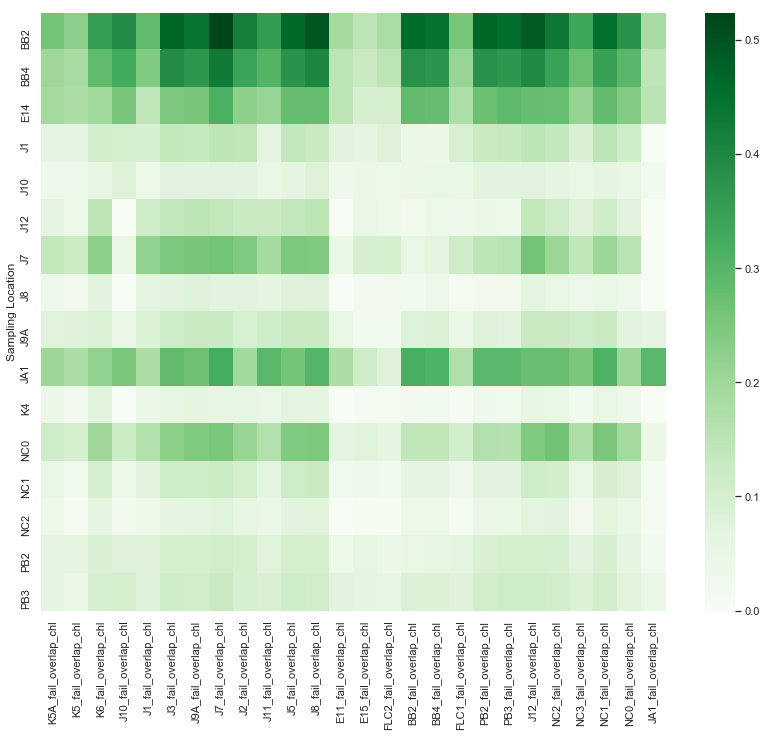

In [4]:
chl_means_df = chl_overlap_df.groupby('Sampling Location').mean()
for i, row in chl_means_df.iterrows():
    if row.sum() <= 1:
        chl_means_df = chl_means_df.drop(index=[i])

for col in chl_means_df:
    if chl_means_df[col].sum() <= 1:
        chl_means_df = chl_means_df.drop(columns=[col])
        
print(chl_means_df.shape)    
_ = plt.figure(figsize=(14, 11))
_ = sns.heatmap(data=chl_means_df, cmap='Greens')

(13, 16)


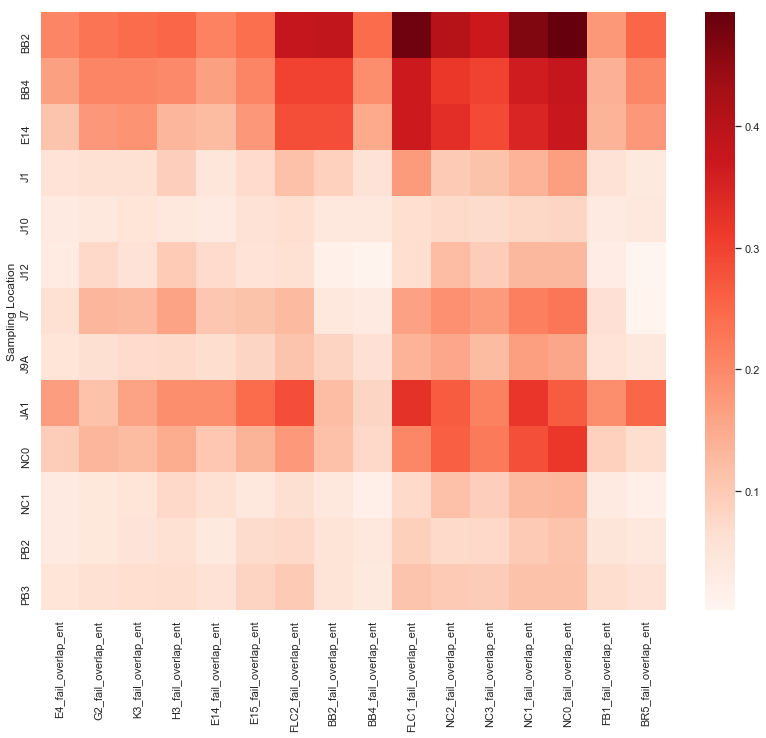

In [5]:
ent_means_df = ent_overlap_df.groupby('Sampling Location').mean()
for i, row in ent_means_df.iterrows():
    if row.sum() <= 1:
        ent_means_df = ent_means_df.drop(index=[i])
for col in ent_means_df:
    if ent_means_df[col].sum() <= 1:
        ent_means_df = ent_means_df.drop(columns=[col])
print(ent_means_df.shape)
_ = plt.figure(figsize=(14, 11))
_ = sns.heatmap(data=ent_means_df, cmap='Reds')

(15, 14)


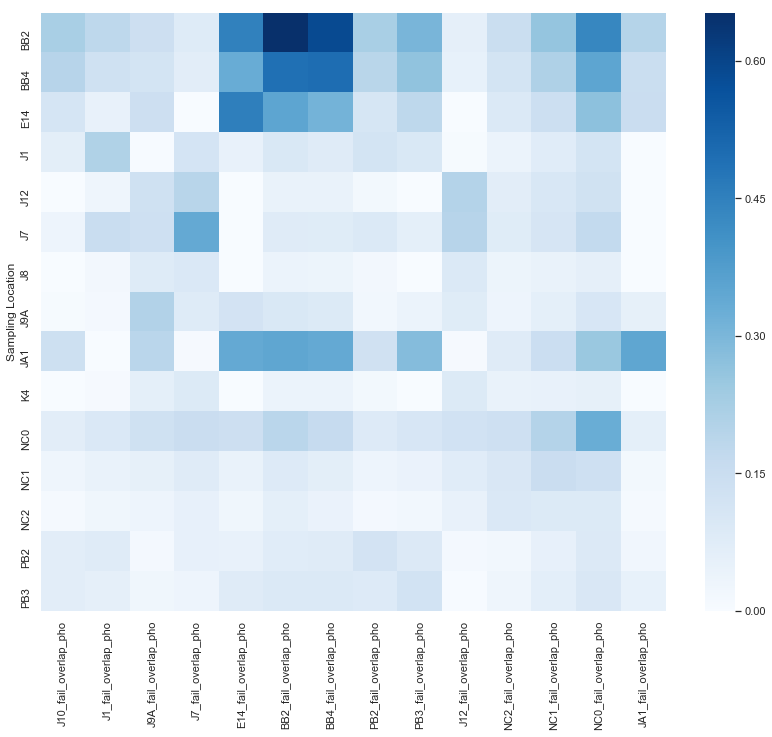

In [6]:
pho_means_df = pho_overlap_df.groupby('Sampling Location').mean()
for i, row in pho_means_df.iterrows():
    if row.sum() <= 1:
        pho_means_df = pho_means_df.drop(index=[i])
for col in pho_means_df:
    if pho_means_df[col].sum() <= 1:
        pho_means_df = pho_means_df.drop(columns=[col])
print(pho_means_df.shape)
_ = plt.figure(figsize=(14, 11))
_ = sns.heatmap(data=pho_means_df, cmap='Blues')

I am going to take the top 10 sites from the phosphate heatmap based on the sum of their probabilities and develop a geospatial representation of their likelihoods. 

Main Goal:
-Create Kriging visualization using pykrige

In [7]:
pho_means_df.sum(axis=0).sort_values(ascending=False)[:10]

BB2_fail_overlap_pho    2.752098
NC0_fail_overlap_pho    2.688822
BB4_fail_overlap_pho    2.556063
E14_fail_overlap_pho    2.095366
NC1_fail_overlap_pho    1.772766
PB3_fail_overlap_pho    1.624444
J9A_fail_overlap_pho    1.477483
J7_fail_overlap_pho     1.452636
PB2_fail_overlap_pho    1.273962
NC2_fail_overlap_pho    1.131586
dtype: float64

In order to perform kriging, data has to be normal. I transform the numeric value of Ortho-phosphorus using np.log.

In [8]:
krige_df = wq_df[wq_df['Sampling Location'].isin(['BB2', 'NC0', 'BB4',
                                                  'E14', 'NC1', 'PB3',
                                                  'J9A', 'J7', 'PB2',
                                                  'NC2'])]
krige_df = krige_df.select_dtypes([np.int64, np.float64])
krige_df = krige_df.drop(columns=['Top Ortho-Phosphorus (mg/L) Failure'])
krige_df['Top Ortho-Phosphorus (mg/L)'] = krige_df['Top Ortho-Phosphorus (mg/L)'].apply(np.log)

In [9]:
import sys

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from pykrige.rk import RegressionKriging
from pykrige.compat import train_test_split

svr_model = SVR(C=0.1, gamma='scale')
rf_model = RandomForestRegressor(n_estimators=100)
lr_model = LinearRegression(normalize=True, copy_X=True, fit_intercept=False)

models = [svr_model, rf_model, lr_model]



p = np.array(krige_df.drop(columns=['Lat', 'Long', 'Top Ortho-Phosphorus (mg/L)']))
x = np.array(krige_df.loc[:, ['Lat', 'Long']])
target = np.array(krige_df.loc[:, 'Top Ortho-Phosphorus (mg/L)'])

p_train, p_test, x_train, x_test, target_train, target_test \
    = train_test_split(p, x, target, test_size=0.3, random_state=42)

fitted_models = dict()
for m in models:
    print('=' * 40)
    print('regression model:', m.__class__.__name__)
    m_rk = RegressionKriging(regression_model=m, n_closest_points=10)
    m_rk.fit(p_train, x_train, target_train)
    fitted_models[m.__class__.__name__] = m_rk
    print('Regression Score: ', m_rk.regression_model.score(p_test, target_test))
    print('RK score: ', m_rk.score(p_test, x_test, target_test))


regression model: SVR
Finished learning regression model
Finished kriging residuals
Regression Score:  -0.008969129484290184
RK score:  0.038294802952512974
regression model: RandomForestRegressor
Finished learning regression model
Finished kriging residuals
Regression Score:  0.6181391137255778
RK score:  0.6244890442533853
regression model: LinearRegression
Finished learning regression model
Finished kriging residuals
Regression Score:  0.3155264398676777
RK score:  0.3026610187927392


Based on these scores, the best model is the Random Forest Regressor as it has the highest Regression Score which means approximately 